# Marketing Mix Model
This project shows a simple marketing mix model, which is a statistical analysis on sales and measures the impact of different channels that have effect on sales. In other words, it quantifies the incremental sales impact and ROI of marketing and non-marketing activities. For example, the model can answer these questions:
- Which factor affects the sales the most?
- What the sales would be if I spend more or less on certain channels or overall marketing?
- How much spend should I allocate on each channel to maximize KPI in the next cycle?

## Dataset
There are three different channels that drives the sales, which is reflected in the columns in the dataset.
- TV
- Radio
- Newspaper

The cost allocated for each channel is collected each week, as shown in the dataset below. We can assume the currency we are using is dollar ($) in this scenario. 

The datset has 200 rows (which records the cost each channel and the sales for each date) x 6 rows (week_dt, TV, radio, newspaper, sales, consumer_index)

## Independent variables and dependent variable
I define the independent variables and dependent variable as below:

- Independent variables: TV, Radio, Newspaper
- Dependent variable: Sales

The dates as an external control is excluded in this scenario, and will be discussed later.

## Analysis and modeling

To determine the goal of modeling, we can ask this question: 
How much of $22.1 of sales was generated by the three advertising channels: TV, radio and newspaper?

The model has the form: Sales = Base + f(TV) + g(Radio) + h(Newspaper)

## Dataset importing

In [3]:
import pandas as pd
import requests
import io
    
# Downloading the csv file from GitHub
url = "https://raw.githubusercontent.com/leopoldavezac/BayesianMMM/main/data/mmm.csv" # Make sure the url is the raw version of the file on GitHub
download = requests.get(url).content

# Reading the downloaded content and turning it into a pandas dataframe
df = pd.read_csv(io.StringIO(download.decode('utf-8')))

## Data exploration and analysis

In [4]:
# Retrieve the first 10 rows of the dataframe
print (df.head(10)) 

      week_dt     TV  radio  newspaper  sales  consumer_index
0  2016-09-01  230.1   37.8       69.2   22.1        3.118934
1  2016-09-08   44.5   39.3       45.1   10.4        3.772289
2  2016-09-15   17.2   45.9       69.3    9.3        6.602882
3  2016-09-22  151.5   41.3       58.5   18.5        4.252269
4  2016-09-29  180.8   10.8       58.4   12.9        4.768575
5  2016-10-06    8.7   48.9       75.0    7.2        4.905612
6  2016-10-13   57.5   32.8       23.5   11.8        2.981743
7  2016-10-20  120.2   19.6       11.6   13.2        4.956583
8  2016-10-27    8.6    2.1        1.0    4.8        2.378291
9  2016-11-03  199.8    2.6       21.2   10.6        2.320300


In [5]:
# Get the summary of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   week_dt         200 non-null    object 
 1   TV              200 non-null    float64
 2   radio           200 non-null    float64
 3   newspaper       200 non-null    float64
 4   sales           200 non-null    float64
 5   consumer_index  200 non-null    float64
dtypes: float64(5), object(1)
memory usage: 9.5+ KB


<AxesSubplot:>

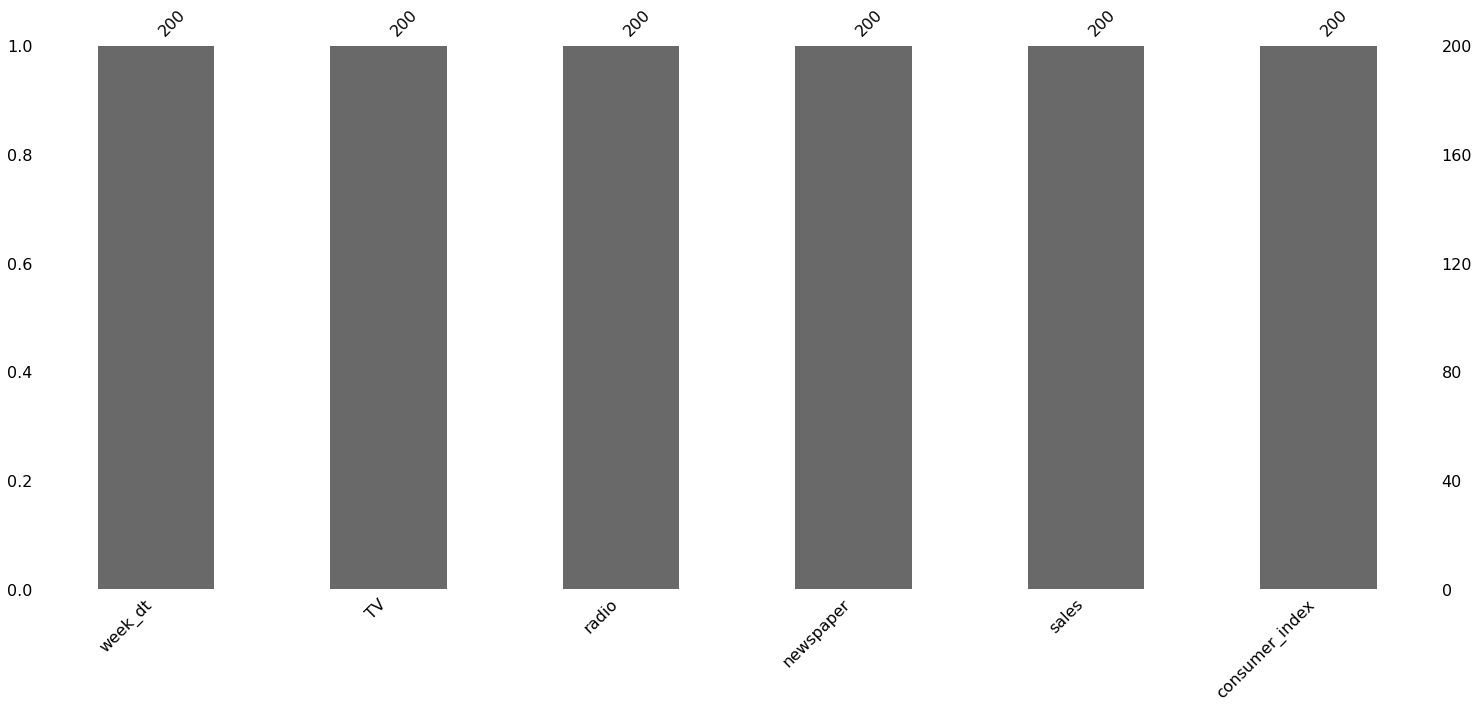

In [6]:
import seaborn as sns
import missingno as msno
%matplotlib inline
import matplotlib.pyplot as plt

# Check non-missing data for each variables
msno.bar(df)

There are no missing or incomplete data in the dataset so no further investigation is needed for a specific channel.

<function matplotlib.pyplot.show(close=None, block=None)>

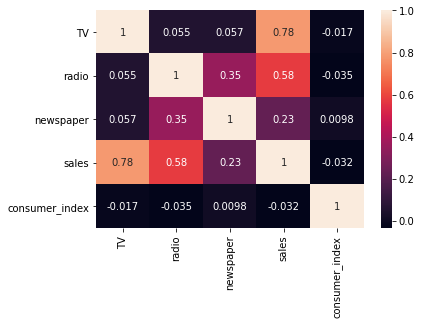

In [7]:
# Build the heatmap that represents the correlation between variables in the dataframe
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot = True)
plt.show

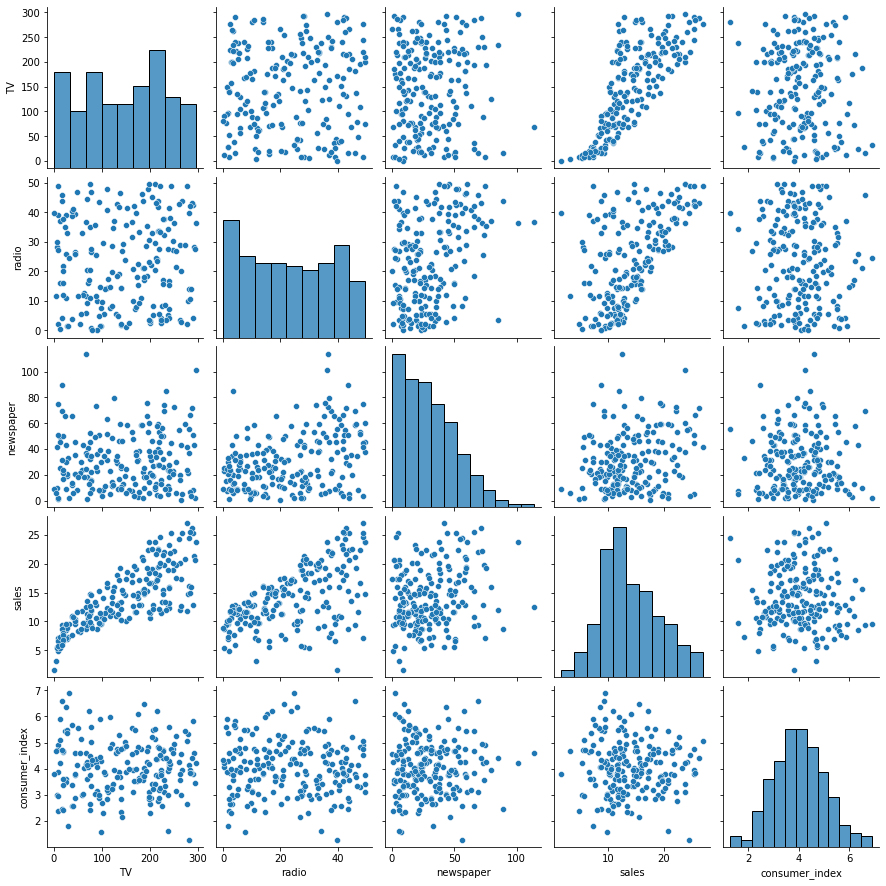

In [8]:
sns.pairplot(df)

From the plots above, it seems our dataset does not show clear multicollinearity, which is a statistical concept where several independent variables in a model are correlated. To check the multicollinearity, we can also use VIF score, an independent variable represents how well the variable is explained by other independent variables. For more information:

VIF = 1, no correlation between the independent variable and the other variables
VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others.

By calculating the VIF as below, we can confirm that our dataset does not have high multicollinearity, which means the cost allocated for each channel does not share a mutual relationship and thus, the dataset is regression-friendly.

In [29]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = df[['TV', 'radio', 'newspaper']]
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                  for i in range(len(X.columns))] 
print(vif_data)

     feature       VIF
0         TV  2.486772
1      radio  3.285462
2  newspaper  3.055245


## Building model

In [10]:
# Slice the dataframe based on our defined independent variables
df = df[['TV', 'radio', 'newspaper','sales']]

In [11]:
# Setting X and y variables
X = df.loc[:, df.columns != 'sales']
y = df['sales']

<AxesSubplot:>

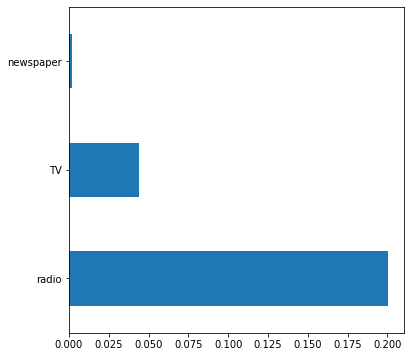

In [44]:
# Determine the importance of each independent variable
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
model_reg = LinearRegression()
# Fit the model
model_reg.fit(X_train, y_train)
# Get the importance
importance = model_reg.coef_
# Visualizing the feature importance
feat_importances = pd.Series(importance, index = X.columns)
feat_importances.nlargest(10).plot(kind = 'barh',figsize = (6,6))

In [45]:
# Estimate the regression 
import statsmodels.formula.api as sm
model_reg = sm.ols(formula="sales~TV+radio+newspaper", data=df).fit()
print(model_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Tue, 30 Aug 2022   Prob (F-statistic):           1.58e-96
Time:                        12:39:23   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.0

## Interpretation
R-Squared is a statistical measure in a regression model that determines the proportion of variance in the dependent variable that can be explained by the independent variable. 

Achieving R-squared at 0.897, it can be inpreted that 87.9% of the variability observed in the sales is explained by the regression model with the formula: sales = 2.9389 + TV(0.0458) + Radio(0.1885)+ Newspaper(-0.0010)

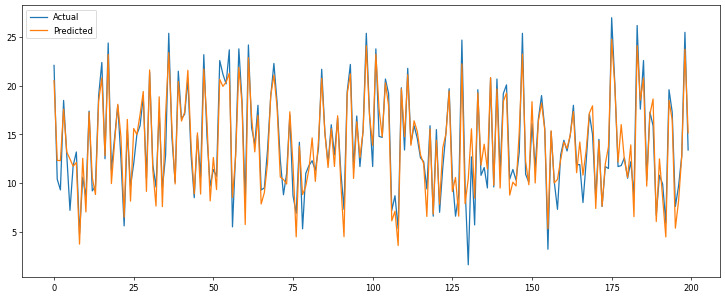

In [46]:
# Defining actual and predicted values
y_pred = model_reg.predict()
labels = df['sales']
df_temp = pd.DataFrame({'Actual': labels, 'Predicted':y_pred})
df_temp.head()
# Data visualization
from matplotlib.pyplot import figure
figure(num = None, figsize = (15, 6), dpi = 60, facecolor = 'w', edgecolor = 'k')
y1 = df_temp['Actual']
y2 = df_temp['Predicted']
plt.plot(y1, label = 'Actual')
plt.plot(y2, label = 'Predicted')
plt.legend()
plt.show()

In [55]:
from sklearn.linear_model import LinearRegression
model_reg = LinearRegression()
# refit the model
model_reg.fit(X, y)
weights = pd.Series(model_reg.coef_, index = X.columns)
base = model_reg.intercept_
#calculate the predicted sale from each channel with base value
unadj_contributions = X.mul(weights).assign(Base = base) 
adj_contributions = (unadj_contributions.div(unadj_contributions.sum(axis=1), axis=0).mul(y, axis=0))
print(adj_contributions)

            TV     radio  newspaper      Base
0    11.339072  7.673670  -0.077308  3.164565
1     1.716658  6.245493  -0.039442  2.477290
2     0.594793  6.538833  -0.054328  2.220702
3     7.288789  8.185462  -0.063805  3.089554
4     8.093142  1.991558  -0.059263  2.874563
..         ...       ...        ...       ...
195   2.474031  0.987174  -0.020262  4.159057
196   5.121297  1.097427  -0.009983  3.491260
197   8.109262  1.755260  -0.006647  2.942126
198  13.925034  8.495515  -0.073689  3.153139
199   9.380651  1.431880  -0.007971  2.595440

[200 rows x 4 columns]


With the coefficient above, we can see that radio is the channel that drives the sales the most, followed by TV and newspaper.
To have a closer look at how the sales is breakdown, the adj_contributions dataframe show the predicted sales from each channel.
For example, on 2016-09-01, the sales from TV, radio, newspaper are \\$11.339072, \\$7.673670, \\$-0.077308 respectively. By adding up with the baseline (the number of sales we would have had without any advertising) at \\$3.164565, the total sales are:

\\$11.339072 + \\$7.673670 + \\$-0.077308 + \\$3.164565 = \\$22.09999 (target value)